In [93]:
import numpy as np
import matplotlib.pyplot as pyp
import sys
import os
import matplotlib
import pandas as pd
import csv
import scipy.interpolate as interpolate
%matplotlib inline

In [94]:
#pyp.style.use('seaborn-talk')
pyp.rcParams['font.size']=16
pyp.rcParams['lines.linewidth']=2

In [95]:
dirc_pre = './'
NFM_dirc = '%s/MountaintopNoiseFigure/'%(dirc_pre)
ant_dirc = "%s/Antennas/"%(dirc_pre)
outDirc = '%s/PredictedSpectra'%(dirc_pre)

In [96]:
speed_of_light = 299792.458 # km / second
kB_W_Hz_K = 1.38064852e-23 # Watts / Hz / K

In [97]:
#functions specfically for fieldfox data
def read_s11(fi):
    freq=[]
    s11db = []

    with open(fi) as csvfi:
	rdr = csv.reader(csvfi)
        for rw in rdr:
            try:
		freq.append(float(rw[0]))
                s11db.append(float(rw[1]))
	    except:
                continue
	return pd.DataFrame({'freq':np.array(freq), 's11db':np.array(s11db)}, index=np.array(freq))

def read_s2p(fi):
    freq=[]
    s11db = []; s12db=[]; s21db=[]; s22db=[];
    s11ang= []; s12ang=[]; s21ang=[]; s22ang=[];
    
    with open(fi) as csvfi:
        rdr = csv.reader(csvfi)
        for rw in rdr:
            row = rw[0].split('\t')
            try:
                if(len(row)==10):
                    freq.append(float(row[0]))
                    s11db.append(float(row[1]))
                    s11ang.append(float(row[2]))
                    s21db.append(float(row[3]))
                    s21ang.append(float(row[4]))
                    s12db.append(float(row[5]))
                    s12ang.append(float(row[6]))
                    s22db.append(float(row[7]))
                    s22ang.append(float(row[8]))
            except:
                continue
    gd11 = group_delay(freq, s11ang); gd12=group_delay(freq, s12ang); gd21=group_delay(freq, s21ang); gd22 = group_delay(freq, s22ang)      
    dct = {'s11dB':s11db, 's11ang':s11ang, 's21dB':s21db, 's21ang':s21ang, 's12dB':s12db, 's12ang':s12ang,'s21dB':s21db, 's21ang':s21ang, 's22dB':s22db, 's22ang':s22ang, 'gd11':gd11, 'gd12':gd12, 'gd21':gd21, 'gd22':gd22, 'freq':freq}
    
    return pd.DataFrame(dct, index=freq)

def read_s1p(fi):
    freq=[]
    s11db = []; 
    s11ang= []; 
    
    with open(fi) as csvfi:
        rdr = csv.reader(csvfi)
        for rw in rdr:
            row = rw[0].split('\t')
            try:
                if(len(row)==3):
                    freq.append(float(row[0]))
                    s11db.append(float(row[1]))
                    s11ang.append(float(row[2]))
	    except:
                continue
    gd11 = group_delay(freq, s11ang);
    dct = {'s11dB':s11db, 's11ang':s11ang, 'gd11':gd11, 'freq':freq}
    
    return pd.DataFrame(dct, index=freq)

def bandwidth(sparm, dBlevel, above=-1, below=-1):

	cut = sparm.s11dB[sparm.s11dB<dBlevel]
	if( above > 0):
		cut = cut[cut.index > above]
	if( below > 0):
		cut = cut[cut.index < below]
	bw_1 = cut.index[0]
	bw_2 = cut.index[-1]
	print dBlevel, "dB Bandwidth: ", bw_1/1e6, " -- ", bw_2/1e6, " MHz"

	return bw_1, bw_2

In [98]:
def group_delay(freq, spang):
    gd = np.zeros(len(freq))
    
    # first continue the phase out linearly
    sp = np.array(spang) + 180.
    c = 1
    for i, s in enumerate(sp):
        if(s > c*180.):
            c += 1
            sp[i:] + 180.
        
    
    for i,f in enumerate(freq[1:-1]):
        dfh = freq[i+1]-freq[i]
        dfl = freq[i]-freq[i-1]
        dfh = freq[i+1]-freq[i]

def reflection_coefficient_from_s11(s11dB):
	return pow(10, s11dB/20.)

def vswr(s11dB):
	# first get gamma
	gamma = reflection_coefficient_from_s11(s11dB)
	# now calculate the VSWR
	vswr = (1.0 + abs(gamma))/(1.0 - abs(gamma))
	return abs(vswr)

In [99]:
def galactic_temperature(f_MHz):
    # Dulk 2001
    nu = f_MHz # Hz
    tau = 5.0 * pow(nu, -2.1)
    Ieg = 1.0610e-20
    Ig  = 2.48e-20
    # Iv in  W/m^2/Hz/sr
    Iv = Ig * pow(nu, -0.52) * (1-np.exp(-tau))/tau + Ieg * pow(nu, -0.80) * np.exp(-tau)

    kB = 1.38064852e-23 # Watts / Hz / K
    c = speed_of_light * 1e3 # m/s
    temp = Iv * c**2 / (2*(nu*1e6)**2)/kB
    ## IV is the intensity
    ## temp is the galactic noise temperature in Kelvin
    return Iv, temp # W/m^2/Hz/sr, K

In [100]:
####################################################################################
def reflection_coefficient(Z_A, Z_L):
    # Z_A is the antenna impedance
    # Z_L is the load impedance characteristic to the system
    return (Z_A - np.conj(Z_L))/(Z_A + Z_L)

def noise_voltage(freq_min_MHz, freq_max_MHz, df,  Z_L,  Z_A, Gain_ant_dB, 
                  Gain_sys_dB = 0, T_sys = 140, T_thermal = 290, frac_sky = 0.5, Nphased=1.):
    # TODO: Include reflection losses at the antennas as (1-Gamma^2)
    #gal_noise = np.sqrt(np.sum(noise_v_sq(np.arange(freq_min_MHz, freq_max_MHz + df, df), Z_L, R_L, Gain_dB, Nphased)*1e6 * df )) 
    #sys_noise = np.sqrt( kB_W_Hz_K * (T_sys) * (freq_max_MHz - freq_min_MHz)*1e6 * Z_L * Nphased)
    
    # calculate the reflection coefficient
    Gamma = reflection_coefficient(Z_A, Z_L)
    eff_load = 1. - np.abs(Gamma)**2
    
    # Radiation resistance of the antennas
    R_A = np.real(Z_A)

    # this is in V
    T_gal = galactic_temperature(np.arange(freq_min_MHz, freq_max_MHz + df, df))[1] 
    # note that the integral is computed using the trapezoidal rule rather thata simple sum to account for edge effects
    gal_noise = np.sqrt(Nphased * np.trapz(T_gal) * frac_sky * eff_load *
                        df * 1e6 * kB_W_Hz_K * Z_L )
    thermal_noise = np.sqrt(Nphased * (T_thermal*(1.-frac_sky) * eff_load) *
                        (freq_max_MHz - freq_min_MHz) * 1e6 * kB_W_Hz_K * Z_L )
    sys_noise = np.sqrt(Nphased * ( T_sys) *
                        (freq_max_MHz - freq_min_MHz) * 1e6 * kB_W_Hz_K * Z_L  ) 

    # assuming we're phasing after the amplifier rather than before.
    # if before, then the system temperature would also decrease as 1/N 
    # note that temperature ~ power, so this is decreasing the noise voltage by 1/sqrt(N)
    # as you would expect from incoherent noise
    
    combined_temp = Nphased*(T_gal * frac_sky * eff_load  +
                             T_thermal * (1.-frac_sky) * eff_load 
                             + T_sys)
    
    #print 'Combined Temp:', combined_temp

    
    # this is in V (rms)
    # note that the integral is computed using the trapezoidal rule rather thata simple sum to account for edge effects
    combined_noise = np.sqrt( np.trapz(combined_temp) * df * 1e6 * kB_W_Hz_K * Z_L )
    
    # amplify everything up by the system gain
    combined_noise *= pow(10., Gain_sys_dB/20)
    gal_noise *= pow(10., Gain_sys_dB/20)
    thermal_noise *= pow(10., Gain_sys_dB/20)
    sys_noise *= pow(10., Gain_sys_dB/20)
    
    combined_noise_power = combined_noise**2 / Z_L
    gal_noise_power = gal_noise**2  / Z_L
    thermal_noise_power = thermal_noise **2 / Z_L
    sys_noise_power = sys_noise **2 / Z_L
    
    return {'combined': combined_noise, 'galactic':gal_noise, 'thermal':thermal_noise, 'system':sys_noise},\
            {'combined': combined_noise_power, 'galactic':gal_noise_power, 'thermal':thermal_noise_power, 'system':sys_noise_power}

In [101]:
def cascade_noise_temp(T_components_K, G_components_dB):
    # Teq = sum ( T_i / G_i-1)
    cascadedT = T_components_K[0]
    cascadedG = pow(10., G_components_dB[0]/10.)
    
    for i, T in enumerate(T_components_K[1:]):
        cascadedT += T/cascadedG
        cascadedG *= pow(10., G_components_dB[i+1]/10)
    return cascadedT

In [102]:
def noiseTemp(noiseFigure_dB, T_ref_K = 290 ):
    return T_ref_K*(pow(10., noiseFigure_dB/10.) - 1.)

def noiseFigure(noiseTemp_K, T_ref_K = 290 ):
    return 10.*np.log10(noiseTemp_K/T_ref_K + 1)

In [103]:
def noise_calcs(NF_components, G_components, fmin, fmax, G_A, frac_sky, 
          T_thermal=290, Z_A=50, Z_L=50, df=10, linestyle='-', legend_pre="", output=None):

    T_components = noiseTemp(NF_components)
    T_sys = T_components
    G_sys = G_components
    #print "Cascaded Temperature: ", Teq, "K, cascaded NF", noiseFigure(Teq), "dB"
    #print "Total amplification", G_sys, " dB"
    
    #Now as function of frequency:
    fmin_list = np.arange(fmin, fmax+df, df)
    BW = df 
    combined_v_list = np.zeros(len(fmin_list))
    galactic_v_list = np.zeros(len(fmin_list))
    system_v_list = np.zeros(len(fmin_list))
    thermal_v_list = np.zeros(len(fmin_list))

    combined_p_list = np.zeros(len(fmin_list))
    galactic_p_list = np.zeros(len(fmin_list))
    system_p_list = np.zeros(len(fmin_list))
    thermal_p_list = np.zeros(len(fmin_list))
    
    for i_f, f in enumerate(fmin_list):
        noises, power = noise_voltage(f, f+df, df, Z_L, 
                     Z_A[i_f], G_A, Gain_sys_dB=G_sys[i_f], 
                     frac_sky=frac_sky, T_sys=T_sys[i_f], T_thermal = T_thermal)

        # correlated noise adds in power not in voltage,
        # so you have to be careful here
        combined_v_list[i_f]= noises['combined']/np.sqrt(BW) 
        galactic_v_list[i_f] = noises['galactic']/np.sqrt(BW)
        system_v_list[i_f] = noises['system']/np.sqrt(BW)
        thermal_v_list[i_f]= noises['thermal']/np.sqrt(BW)

        combined_p_list[i_f]= (power['combined']) / BW #
        #combined_p_list[i_f]= (power['galactic']+power['system']+power['thermal']) / BW #/np.sqrt(BW) 
        galactic_p_list[i_f] = power['galactic'] / BW #
        system_p_list[i_f] = power['system'] / BW    #
        thermal_p_list[i_f]= power['thermal'] / BW   #

    pyp.figure(1,figsize=(8,6))
    pyp.semilogy(fmin_list, combined_p_list, 'ro-', label='%scombined'%(legend_pre), linestyle=linestyle, linewidth=3)
    pyp.plot(fmin_list, galactic_p_list,'bo-', label='%sgalactic'%(legend_pre), linestyle=linestyle, linewidth=2)
    pyp.plot(fmin_list, thermal_p_list, 'ko-', label='%sground'%(legend_pre), linestyle=linestyle,  linewidth=2)
    #if( T_sys> 0):
    pyp.plot(fmin_list, system_p_list,'#17AF25', label='%ssystem'%(legend_pre), linestyle=linestyle, linewidth=2)

    pyp.legend(loc=[1.02,0.],labelspacing=0.1)
    pyp.xlabel("Frequency (MHz)")
    pyp.ylabel("Noise Power ($W/MHz$)")
    pyp.xlim(fmin,fmax)
    pyp.grid(True, which='both',alpha=0.5)

    pyp.figure(2,figsize=(8,6))
    pyp.plot(fmin_list, 10.*np.log10(combined_p_list*1e3),'r', label='%scombined'%(legend_pre), linestyle=linestyle, linewidth=3)
    pyp.plot(fmin_list, 10.*np.log10(galactic_p_list*1e3), 'b', label='%sgalactic'%(legend_pre), linestyle=linestyle, linewidth=2)
    pyp.plot(fmin_list, 10.*np.log10(thermal_p_list*1e3),'k', label='%sground'%(legend_pre), linestyle=linestyle, linewidth=2)
    #if( T_sys>0):
    pyp.plot(fmin_list, 10.*np.log10(system_p_list*1e3),'#17AF25', label='%ssystem'%(legend_pre), linestyle=linestyle, linewidth=2)

    pyp.legend(loc=[1.02,0.], labelspacing=0.1)
    pyp.xlabel("Frequency (MHz)")
    pyp.ylabel("Noise Power dB($mW/MHz$)")
    pyp.xlim(fmin,fmax)
    pyp.grid(True, which='both',alpha=0.5)
        

    #noises_full, power_full = noise_voltage(fmin, fmax, df, Z_L, Z_A, G_A, Gain_sys_dB = G_sys, frac_sky=frac_sky, T_sys=T_sys, T_thermal = T_thermal)
    #print "%d-%d MHz:"%(fmin, fmax)
    #print "Full band:"
    #print "\tcombined noise power: ", power_full['combined']*1e6, "microW",
    #print 1e6*(power_full['galactic']+power_full['thermal']+power_full['system']), "microW"
    #print "\tgalactic noise power: ", power_full['galactic']*1e6, "microW"
    #print "\tsystem noise power: ", power_full['system']*1e6, "microW"
    #print "\tthermal noise power: ", power_full['thermal']*1e6, "microW"

    #print "Spectral Sums:"
    #print "\tCombined Noise Power", np.sum(combined_p_list)*1e6*BW, "microW", 
    #print 1e6*BW*( np.sum(galactic_p_list) + np.sum(thermal_p_list) + np.sum(system_p_list)),"microW" 
   #print "\tGalactic Noise Power", np.sum(galactic_p_list)*1e6*BW, "microW"
    #print "\tSystem Noise Power", np.sum(system_p_list)*1e6*BW, "microW"
    #print "\tThermal Noise Power", np.sum(thermal_p_list)*1e6*BW, "microW"
    
    #print "The combined noise voltage should add in quadarature, while the combined noise power should add linearly."
    #print "Combined noise : ", noises_full['combined'], "V" 
    #print "\t", power_full['combined']*1e6, "microW", noises_full['combined']**2/Z_L*1e6,\
     #   10*np.log10(power_full['combined']*1e3), "dBm" 
    #print "Galactic noise : ", noises_full['galactic'], "V"
    #print "\t", power_full['galactic']*1e6, "microW", \
      #  10*np.log10(power_full['galactic']*1e3), "dBm" 
    #print "Thermal noise : ", noises_full['thermal'], "V"
    #print "\t",   power_full['thermal'] *1e6, "microW", \
     #   10*np.log10(power_full['thermal']*1e3), "dBm" 
    #print "System noise : ", noises_full['system'], "V"
    #print "\t",    power_full['system']*1e6, "microW", \
     #   10*np.log10(power_full['system']*1e3), "dBm" 

    
    #print noises_full['combined'], "V", np.sqrt(noises_full['galactic']**2 + noises_full['thermal']**2 + noises_full['system']**2), 'V'
    #print power_full['combined']*1e6, "microW", 1e6*(power_full['galactic'] + power_full['thermal'] + power_full['system']), "microW"
    if ( output != None):
        data = pd.DataFrame({'frequency_MHz':fmin_list,
                          'combined_power_W_per_MHz':combined_p_list, 
                          'galactic_power_W_per_MHz':galactic_p_list,
                           'ground_power_W_per_MHz'  :thermal_p_list,
                           'system_power_W_per_MHz'  :system_p_list})
        data.to_csv(output)

# UHF System

## Predicted based on measured gain / noise figure

In [104]:
boxno = 2
freqband = 'UHF'
df1 = pd.read_csv('%sStage1-%s-Box%d-10MHzStep.txt'%(NFM_dirc,freqband,boxno),
                 names=['freq_hz', 'gain_dB', 'noisefig_dB'], skiprows=1, dtype=float)
df2 = pd.read_csv('%sStage2-%s-Box%d-10MHzStep.txt'%(NFM_dirc,freqband,boxno),
                 names=['freq_hz', 'gain_dB', 'noisefig_dB'], skiprows=1, dtype=float)

/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


(0, 1200)

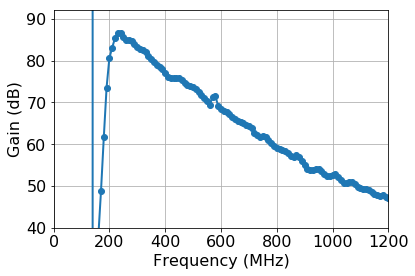

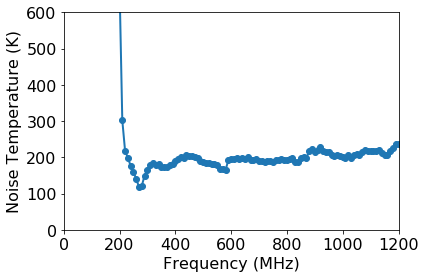

In [105]:
NF_components = np.array(df1.noisefig_dB, df2.noisefig_dB) #Stage 1 and Stage 2
T_components = noiseTemp(NF_components)
G_components = df1.gain_dB + df1.gain_dB
#print G_components

pyp.figure()
pyp.plot(df1.freq_hz/1e6, G_components, 'o-')
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Gain (dB)")
pyp.ylim(40,92)
pyp.xlim(0,1200)
pyp.grid(True)

pyp.figure()
pyp.plot(df1.freq_hz/1e6, T_components, 'o-')
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Noise Temperature (K)")
pyp.ylim(0,600)
pyp.xlim(0,1200)

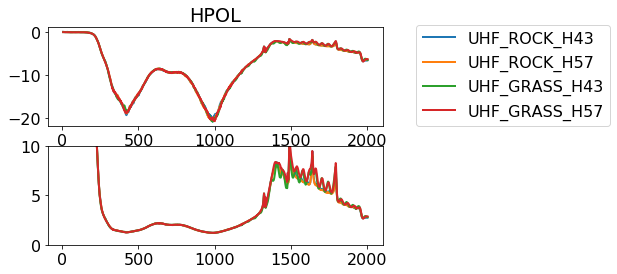

In [106]:
# now get the reflection coefficient of the antenna
titles=['UHF_ROCK_H43', 'UHF_ROCK_H57', 'UHF_GRASS_H43', 'UHF_GRASS_H57']
for title in titles:
    sparm = read_s2p(ant_dirc + title + '.s2p')
    pyp.subplot(2,1,1)
    pyp.plot(sparm.freq/1e6, sparm.s11dB, label=title)
    pyp.subplot(2,1,2)
    pyp.plot(sparm.freq/1e6, vswr(sparm.s11dB))
    pyp.ylim(0,10)

pyp.subplot(2,1,1)
pyp.legend(loc=[1.1,0.])
pyp.title("HPOL")
sparm = read_s2p(ant_dirc + titles[0] + '.s2p')
Gamma= reflection_coefficient_from_s11(sparm.s11dB)

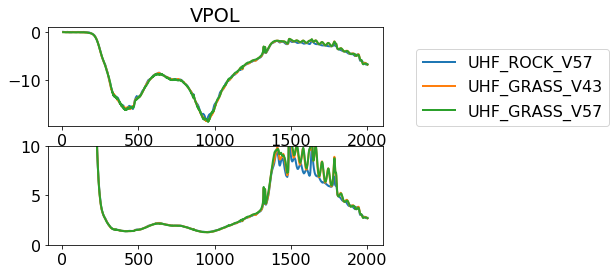

In [107]:
# now get the reflection coefficient of the antenna
titles=['UHF_ROCK_V57', 'UHF_GRASS_V43', 'UHF_GRASS_V57']
for title in titles:
    sparm = read_s2p(ant_dirc + title + '.s2p')
    pyp.subplot(2,1,1)
    pyp.plot(sparm.freq/1e6, sparm.s11dB, label=title)
    pyp.subplot(2,1,2)
    pyp.plot(sparm.freq/1e6, vswr(sparm.s11dB))
    pyp.ylim(0,10)

pyp.subplot(2,1,1)
pyp.legend(loc=[1.1,0.])
pyp.title("VPOL")
sparm = read_s2p(ant_dirc + titles[0] + '.s2p')
Gamma= reflection_coefficient_from_s11(sparm.s11dB)

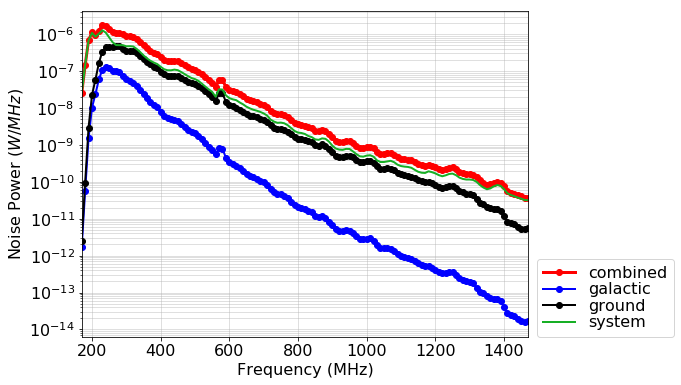

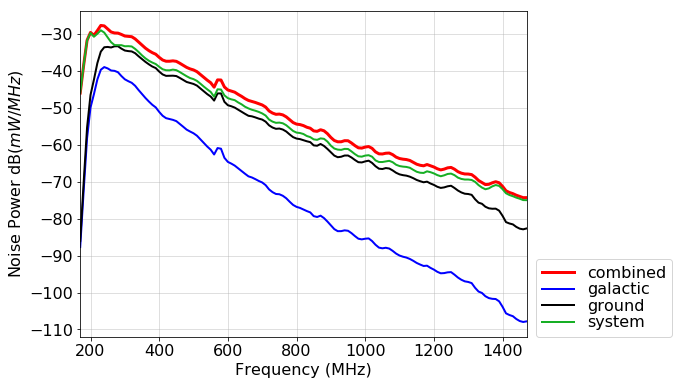

In [108]:
Z_A = 50 * np.divide((1+Gamma),(1-Gamma)) #calculate input impedance from refl. coeff referenced to 50 Ohm
#Z_A = np.ones(len(G_components))*50
#print Z_A

fmin = 170
fmax = 1470
df = 10.
frac_sky = 0.5

outfile = '%s/%d-%dMHZ_fracsky%1.2f_SeaveyAntenna_Box%d.csv'%(outDirc,fmin,fmax, frac_sky, boxno)


# The noise figure, gaiint and antenna impedance are
# functions of frequency.
#
# Set up some linear interpolators to handle the frequency range of interest
noise_fig_func = interpolate.interp1d( df1.freq_hz/1e6, NF_components)
gain_func = interpolate.interp1d(df1.freq_hz/1e6, G_components)
ZA_func = interpolate.interp1d(sparm.freq/1e6,Z_A)

freq = np.arange(fmin, fmax+df, df)
interp_NF = noise_fig_func(freq)
interp_Gain = gain_func(freq)
interp_ZA = ZA_func(freq)

noise_calcs(NF_components = interp_NF, G_components=interp_Gain, fmin=fmin, fmax=fmax, G_A=1.8, 
    frac_sky=frac_sky, T_thermal=290,Z_A=interp_ZA, Z_L=50,output = outfile)

pyp.figure(1)
pyp.savefig("%s/predicted_spectra_UHFSeavey_Box%d_lin_%d-%dMHz_fracsky%1.2f.pdf"%
            (outDirc,boxno,fmin, fmax, frac_sky),bbox_inches='tight')
pyp.figure(2)
pyp.savefig("%s/predicted_spectra_UHFSeavey_Box%d_log_%d-%dMHz_fracsky%1.2f.pdf"%
            (outDirc,boxno,fmin, fmax, frac_sky),bbox_inches='tight')

/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10


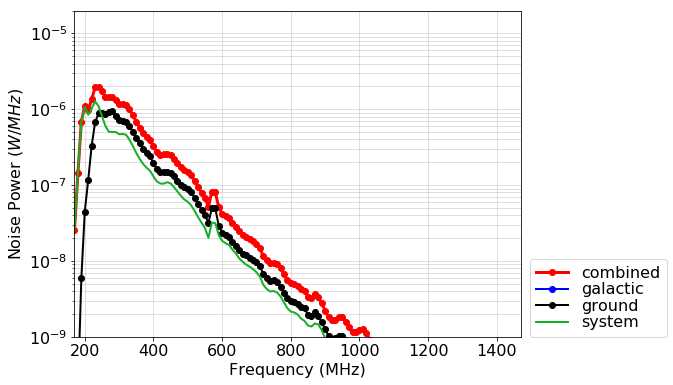

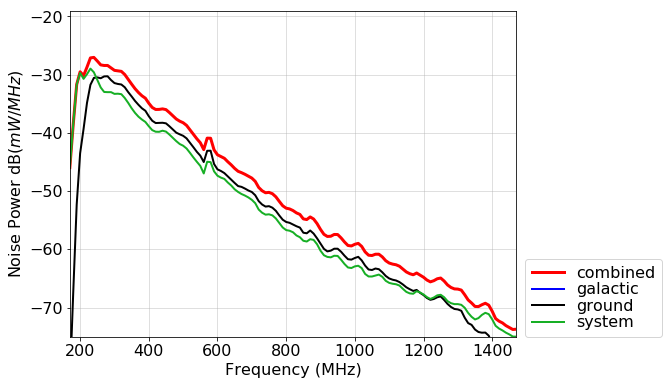

In [109]:
Z_A = 50 * np.divide((1+Gamma),(1-Gamma)) #calculate input impedance from refl. coeff referenced to 50 Ohm
#Z_A = np.ones(len(G_components))*50
#print Z_A

fmin = 170
fmax = 1470
df = 10.
frac_sky = 0.0

outfile = '%s/%d-%dMHZ_fracsky%1.2f_SeaveyAntenna_Box%d.csv'%(outDirc,fmin,fmax, frac_sky, boxno)

# The noise figure, gaiint and antenna impedance are
# functions of frequency.
#
# Set up some linear interpolators to handle the frequency range of interest
noise_fig_func = interpolate.interp1d( df1.freq_hz/1e6, NF_components)
gain_func = interpolate.interp1d(df1.freq_hz/1e6, G_components)
ZA_func = interpolate.interp1d(sparm.freq/1e6,Z_A)

freq = np.arange(fmin, fmax+df, df)
interp_NF = noise_fig_func(freq)
interp_Gain = gain_func(freq)
interp_ZA = ZA_func(freq)

noise_calcs(NF_components = interp_NF, G_components=interp_Gain, fmin=fmin, fmax=fmax, G_A=1.8, 
    frac_sky=frac_sky, T_thermal=290,Z_A=interp_ZA, Z_L=50,output = outfile)

pyp.figure(1)
pyp.ylim(1e-9, 2e-5)
pyp.savefig("%s/predicted_spectra_TerminatedInput_Box%d_lin_%d-%dMHz_fracsky%1.2f.pdf"%
            (outDirc,boxno,fmin, fmax, frac_sky),bbox_inches='tight')

pyp.figure(2)
pyp.ylim(-75, -19)
pyp.savefig("%s/predicted_spectra_TerminatedInput_Box%d_log_%d-%dMHz_fracsky%1.2f.pdf"%
            (outDirc,boxno,fmin, fmax, frac_sky),bbox_inches='tight')



# VHF System

## Predicted based on measured gain / noise figure

In [110]:
boxno = 2
if( boxno == 1):
    s1_suffix = '-Run7'
    s2_suffix = ''
elif( boxno == 2):
    s1_suffix = '-25FilterRun2'
    s2_suffix = '-25FilterRun2'
freqband = 'VHF'

df1 = pd.read_csv('%sStage1-%s-Box%d-10MHzStep%s.txt'%(NFM_dirc,freqband,boxno, s1_suffix),
                 names=['freq_hz', 'gain_dB', 'noisefig_dB'], skiprows=1, dtype=float)
df2 = pd.read_csv('%sStage2-%s-Box%d-10MHzStep%s.txt'%(NFM_dirc,freqband,boxno, s2_suffix),
                 names=['freq_hz', 'gain_dB', 'noisefig_dB'], skiprows=1, dtype=float)

/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


(0, 300)

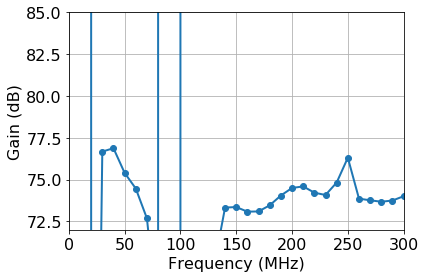

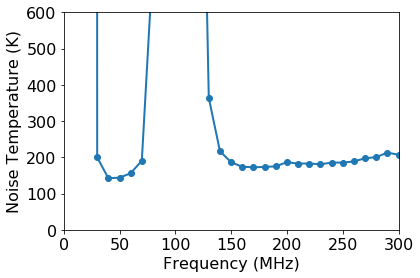

In [111]:
NF_components = np.array(df1.noisefig_dB, df2.noisefig_dB) #Stage 1 and Stage 2
T_components = noiseTemp(NF_components)
G_components = df1.gain_dB + df1.gain_dB
#print G_components

pyp.figure()
pyp.plot(df1.freq_hz/1e6, G_components, 'o-')
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Gain (dB)")
pyp.ylim(72,85)
pyp.xlim(0,300)
pyp.grid(True)

pyp.figure()
pyp.plot(df1.freq_hz/1e6, T_components, 'o-')
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Noise Temperature (K)")
pyp.ylim(0,600)
pyp.xlim(0,300)

In [112]:
def gamma_from_vswr(vswr):
    return (vswr - 1)/(vswr+1)

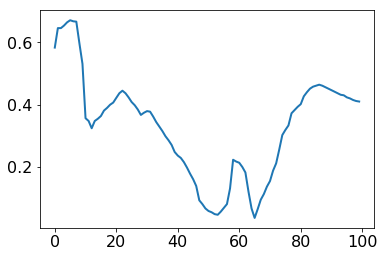

In [113]:
# now get the reflection coefficient of the antenna
bicone_vswr = pd.read_csv(ant_dirc + 'VHF_AntennaVSWR.csv', 
                   names=['freq_MHz', 'VSWR',],usecols=[0,1], 
                   skiprows=1,dtype='float')

man_Gamma_freq = bicone_vswr.index.values
man_Gamma = gamma_from_vswr(bicone_vswr.VSWR.values)

# Assume a perfect antenna by setting the reflection coefficient to 0
#Gamma = np.zeros(len(Gamma)) 
pyp.plot(man_Gamma_freq, man_Gamma)

Text(0,0.5,u'VSWR')

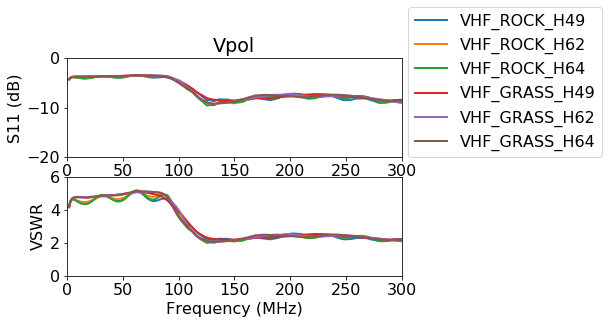

In [114]:
# now get the reflection coefficient of the antenna
titles = ['VHF_ROCK_H49', 'VHF_ROCK_H62', 'VHF_ROCK_H64',
          'VHF_GRASS_H49', 'VHF_GRASS_H62', 'VHF_GRASS_H64']
for title in titles: 
    sparm = read_s2p(ant_dirc + "%s.s2p"%title)
    pyp.subplot(2,1,1)
    pyp.plot(sparm.freq/1e6, sparm.s11dB, label=title)
    pyp.subplot(2,1,2)
    pyp.plot(sparm.freq/1e6, vswr(sparm.s11dB))

pyp.subplot(2,1,1)
pyp.title("Vpol")
pyp.xlim(0,300)
pyp.ylim(-20,0)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("S11 (dB)")
pyp.legend(loc=[1.02,0])

pyp.subplot(2,1,2)
pyp.xlim(0,300)
pyp.ylim(0,6)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("VSWR")

Text(0,0.5,u'VSWR')

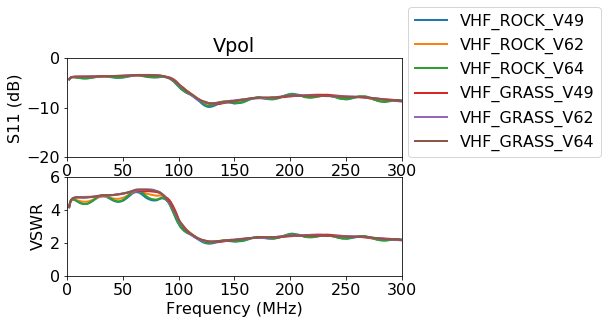

In [115]:
# now get the reflection coefficient of the antenna
titles = ['VHF_ROCK_V49', 'VHF_ROCK_V62', 'VHF_ROCK_V64',
          'VHF_GRASS_V49', 'VHF_GRASS_V62', 'VHF_GRASS_V64']
for title in titles: 
    sparm = read_s2p(ant_dirc + "%s.s2p"%title)
    pyp.subplot(2,1,1)
    pyp.plot(sparm.freq/1e6, sparm.s11dB, label=title)
    pyp.subplot(2,1,2)
    pyp.plot(sparm.freq/1e6, vswr(sparm.s11dB))

pyp.subplot(2,1,1)
pyp.title("Vpol")
pyp.xlim(0,300)
pyp.ylim(-20,0)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("S11 (dB)")
pyp.legend(loc=[1.02,0])

pyp.subplot(2,1,2)
pyp.xlim(0,300)
pyp.ylim(0,6)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("VSWR")



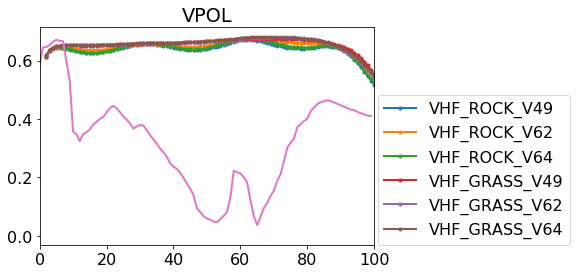

In [116]:
for title in titles:
    sparm = read_s2p(ant_dirc + "%s.s2p"%title)
    Gamma= reflection_coefficient_from_s11(sparm.s11dB)
    Gamma_freq  = sparm.freq/1e6
    pyp.plot(Gamma_freq, Gamma,'.-', label=title)

pyp.legend(loc=[1.01,0])
pyp.plot(man_Gamma_freq, man_Gamma)
pyp.xlim(0,100)
pyp.title("VPOL")

title='VHF_ROCK_V64'
sparm = read_s2p(ant_dirc + "%s.s2p"%title)
Gamma= reflection_coefficient_from_s11(sparm.s11dB)
Gamma_freq  = sparm.freq/1e6

#Gamma = man_Gamma
#Gamma_freq = man_Gamma_freq

/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in double_scalars
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in double_scalars
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10


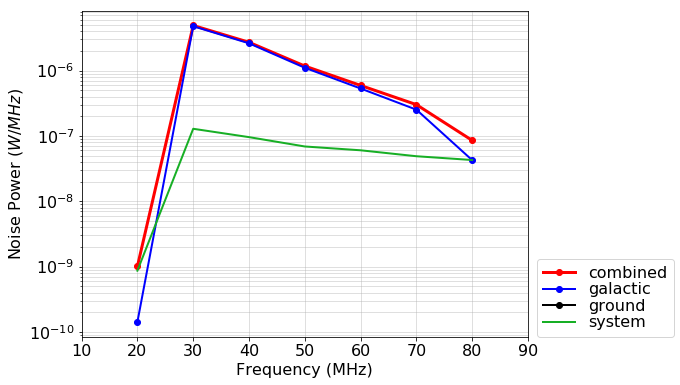

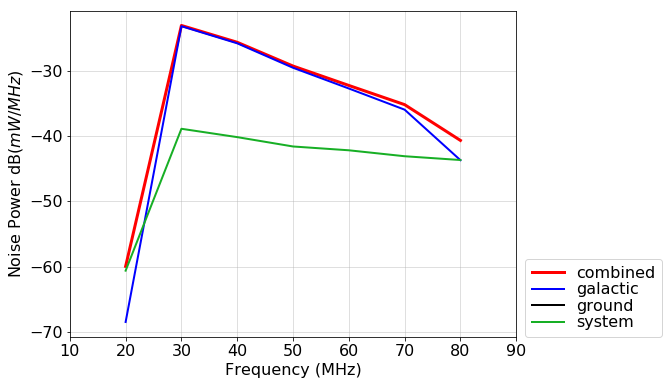

In [117]:
Z_A = 50 * np.divide((1.+Gamma),(1.-Gamma)) #calculate input impedance from refl. coeff referenced to 50 Ohm
#Z_A = np.ones(len(G_components))*50
#print Z_A

fmin = 10
fmax = 90.
df = 10.
frac_sky = 1.0
T_thermal = 290.

outfile = '%s/%d-%dMHZ_fracsky%1.2f_BiconeAntenna_Box%d.csv'%(outDirc,fmin,fmax, frac_sky, boxno)


# The noise figure, gaiint and antenna impedance are
# functions of frequency.
#
# Set up some linear interpolators to handle the frequency range of interest
noise_fig_func = interpolate.interp1d( df1.freq_hz/1e6, NF_components)
gain_func = interpolate.interp1d(df1.freq_hz/1e6, G_components)
ZA_func = interpolate.interp1d(Gamma_freq,Z_A)

freq = np.arange(fmin, fmax+df, df)
interp_NF = noise_fig_func(freq)
interp_Gain = gain_func(freq)
interp_ZA = ZA_func(freq)

noise_calcs(NF_components = interp_NF, G_components=interp_Gain, fmin=fmin, fmax=fmax, G_A=1.8, 
    df=df, frac_sky=frac_sky, T_thermal=290,Z_A=interp_ZA, Z_L=50,output = outfile)

pyp.figure(1)
pyp.savefig("%s/predicted_spectra_VHFBicone_Box%d_lin_%d-%dMHz_fracsky%1.2f.pdf"%
            (outDirc,boxno,fmin, fmax, frac_sky),bbox_inches='tight')
pyp.figure(2)
pyp.savefig("%s/predicted_spectra_VHFBicone_Box%d_log_%d-%dMHz_fracsky%1.2f.pdf"%
            (outDirc,boxno,fmin, fmax, frac_sky),bbox_inches='tight')

/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in double_scalars
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in double_scalars
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars
/datapool/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10


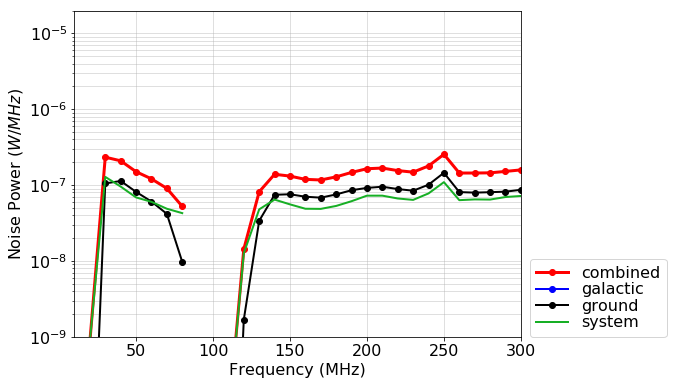

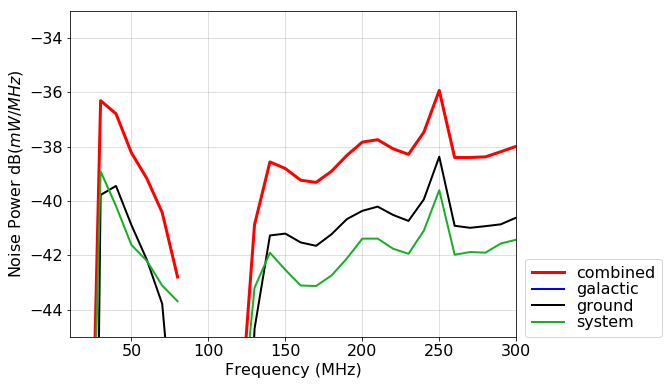

In [118]:
Z_A = 50 * np.divide((1+Gamma),(1-Gamma)) #calculate input impedance from refl. coeff referenced to 50 Ohm
#Z_A = np.ones(len(G_components))*50
#print Z_A

fmin = 10.
fmax = 300.
df = 10.
frac_sky = 0.0

outfile = '%s/%d-%dMHZ_fracsky%1.2f_TerminatedInput_Box%d.csv'%(outDirc,fmin,fmax, frac_sky, boxno)

# The noise figure, gaiint and antenna impedance are
# functions of frequency.
#
# Set up some linear interpolators to handle the frequency range of interest
noise_fig_func = interpolate.interp1d( df1.freq_hz/1e6, NF_components)
gain_func = interpolate.interp1d(df1.freq_hz/1e6, G_components)
ZA_func = interpolate.interp1d(Gamma_freq,Z_A)

freq = np.arange(fmin, fmax+df, df)
interp_NF = noise_fig_func(freq)
interp_Gain = gain_func(freq)
interp_ZA = ZA_func(freq)

noise_calcs(NF_components = interp_NF, G_components=interp_Gain, fmin=fmin, fmax=fmax, G_A=1.8, 
    frac_sky=frac_sky, T_thermal=290,Z_A=interp_ZA, Z_L=50,output = outfile)

pyp.figure(1)
pyp.ylim(1e-9, 2e-5)
pyp.savefig("%s/predicted_spectra_TerminatedInput_Box%d_lin_%d-%dMHz_fracsky%1.2f.pdf"%
            (outDirc,boxno,fmin, fmax, frac_sky),bbox_inches='tight')

pyp.figure(2)
pyp.ylim(-45, -33)
pyp.savefig("%s/predicted_spectra_TerminatedInput_Box%d_log_%d-%dMHz_fracsky%1.2f.pdf"%
            (outDirc,boxno,fmin, fmax, frac_sky),bbox_inches='tight')